Import neccessary packages

In [ ]:
#MOHAMMED FADIKA
#COMPUTATIONAL PERCEPTION - AI4126
#END OF SEMESTER EXAMIANTION - CODE IMPLEMENTATION

In [43]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.optimizers.legacy import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

In [44]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/Users/mohammed/Desktop/ACADEMICS/LEVEL 400/SEMESTER 1/COMPUTATIONAL PERCEPTION/PlantVillage'
width=256
height=256
depth=3

Function to convert images to array

In [45]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Fetch images from directory

In [46]:
import os
from os import listdir

image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    
    # Remove .DS_Store from the root directory list
    root_dir = [d for d in root_dir if d != ".DS_Store"]

    for plant_folder in root_dir:
        plant_folder_path = os.path.join(directory_root, plant_folder)
        
        # Ensure the item is a directory
        if not os.path.isdir(plant_folder_path):
            continue
        
        plant_disease_folder_list = listdir(plant_folder_path)
        plant_disease_folder_list = [d for d in plant_disease_folder_list if d != ".DS_Store"]

        for plant_disease_folder in plant_disease_folder_list:
            plant_disease_folder_path = os.path.join(plant_folder_path, plant_disease_folder)
            
            # Ensure the item is a directory
            if not os.path.isdir(plant_disease_folder_path):
                continue

            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(plant_disease_folder_path)
            plant_disease_image_list = [f for f in plant_disease_image_list if f != ".DS_Store"]

            for image in plant_disease_image_list[:200]:
                image_path = os.path.join(plant_disease_folder_path, image)
                
                # Ensure it's a valid image file
                if image_path.endswith(".jpg") or image_path.endswith(".JPG"):
                    image_list.append(convert_image_to_array(image_path))
                    label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")
    
except Exception as e:
    print(f"Error : {e}")


[INFO] Loading images ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___healthy ...
[INFO] Image loading completed


Get Size of Processed Image

In [47]:
image_size = len(image_list)

Transform Image Labels uisng [Scikit Learn](http://scikit-learn.org/)'s LabelBinarizer

In [48]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

Print the classes

In [49]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [50]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [13]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [51]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [52]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Model Summary

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 activation_7 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_6 (Bat  (None, 256, 256, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 85, 85, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 85, 85, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 85, 85, 64)       

In [53]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [54]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(np.argmax(y_train, axis=1)), 
    y=np.argmax(y_train, axis=1)
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)


history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    verbose=1,
    class_weight=class_weights_dict)

Class Weights: {0: 0.971604938271605, 1: 0.9481927710843373, 2: 0.98375, 3: 0.9656441717791411, 4: 1.2693548387096774, 5: 0.98375, 6: 0.9258823529411765, 7: 1.0154838709677418, 8: 1.0287581699346404, 9: 0.971604938271605, 10: 1.0220779220779221, 11: 0.971604938271605, 12: 1.0780821917808219, 13: 0.9313609467455621, 14: 1.0154838709677418}
Epoch 1/25


2024-12-18 12:05:04.656548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


73/73 [==============================] - ETA: 0s - loss: 0.5523 - accuracy: 0.1078

2024-12-18 12:13:48.433163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


73/73 [==============================] - 531s 7s/step - loss: 0.5523 - accuracy: 0.1078 - val_loss: 0.3847 - val_accuracy: 0.0677
Epoch 2/25
73/73 [==============================] - 63s 832ms/step - loss: 0.1992 - accuracy: 0.4392 - val_loss: 0.3183 - val_accuracy: 0.0677
Epoch 3/25
73/73 [==============================] - 57s 775ms/step - loss: 0.1532 - accuracy: 0.5590 - val_loss: 0.3014 - val_accuracy: 0.0660
Epoch 4/25
73/73 [==============================] - 54s 740ms/step - loss: 0.1317 - accuracy: 0.6565 - val_loss: 0.3231 - val_accuracy: 0.0914
Epoch 5/25
73/73 [==============================] - 65s 889ms/step - loss: 0.2714 - accuracy: 0.3164 - val_loss: 0.2683 - val_accuracy: 0.0981
Epoch 6/25
73/73 [==============================] - 58s 786ms/step - loss: 0.1909 - accuracy: 0.4792 - val_loss: 0.2708 - val_accuracy: 0.1438
Epoch 7/25
73/73 [==============================] - 63s 856ms/step - loss: 0.2129 - accuracy: 0.3933 - val_loss: 0.2448 - val_accuracy: 0.0592
Epoch 8/25
7

Plot the train and val curve

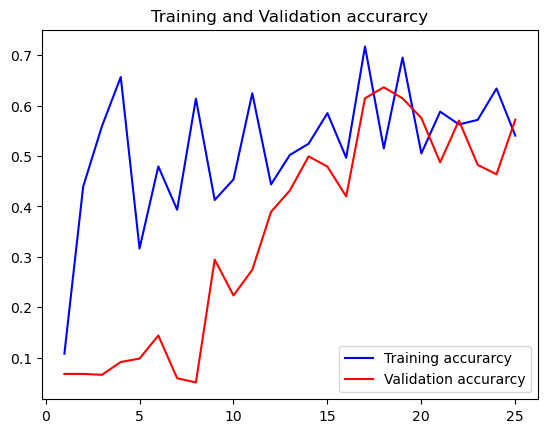

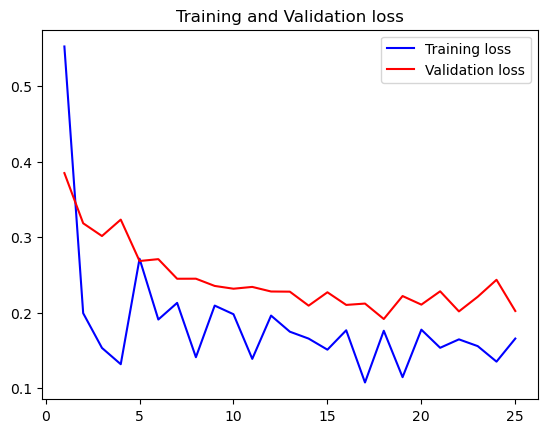

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Model Accuracy

In [56]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 [==============================] - 3s 155ms/step - loss: 0.2032 - accuracy: 0.5685
Test Accuracy: 56.85279369354248


2024-12-18 12:40:02.343508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 4s 173ms/step


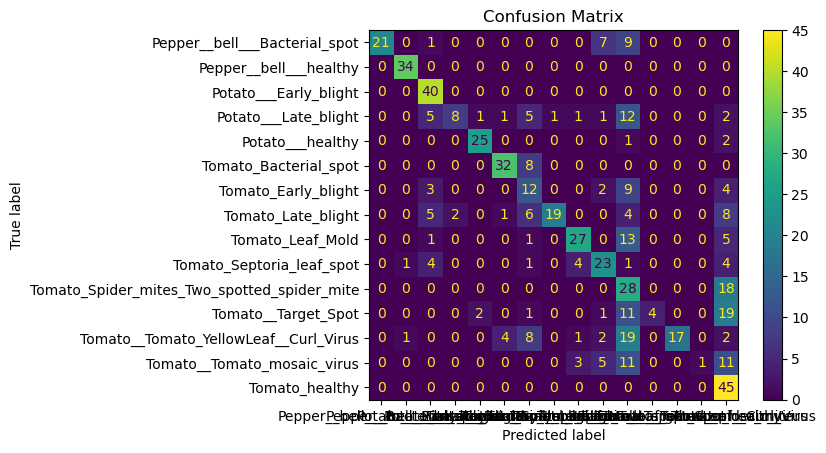

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      0.55      0.71        38
                     Pepper__bell___healthy       0.94      1.00      0.97        34
                      Potato___Early_blight       0.68      1.00      0.81        40
                       Potato___Late_blight       0.80      0.22      0.34        37
                           Potato___healthy       0.89      0.89      0.89        28
                      Tomato_Bacterial_spot       0.84      0.80      0.82        40
                        Tomato_Early_blight       0.29      0.40      0.33        30
                         Tomato_Late_blight       0.95      0.42      0.58        45
                           Tomato_Leaf_Mold       0.75      0.57      0.65        47
                  Tomato_Septoria_leaf_spot       0.56      0.61      0.58        38
Tomato_Spider_mites_Two_spotted_spider_mi

In [57]:
# Generate predictions for the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices
y_true = np.argmax(y_test, axis=1)

# Compute and display the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_binarizer.classes_)
disp.plot(cmap="viridis")
plt.title("Confusion Matrix")
plt.show()

# Print precision, recall, and F1-score
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_binarizer.classes_))

Save model using Pickle

In [58]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...
